In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
import pickle

# --- Sklearn Imports (for Preprocessing, Splitting, and Metrics) ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer # <-- This is CRITICAL for this dataset
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.exceptions import ConvergenceWarning

# --- For 3D Plotting ---
from mpl_toolkits.mplot3d import Axes3D

# --- For Progress Bars ---
from tqdm.notebook import tqdm

# --- Suppress Warnings ---
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# --- Matplotlib Setup ---
%matplotlib inline
sns.set(style="whitegrid", palette="deep")

print("All libraries imported successfully.")

All libraries imported successfully.


In [2]:
# --- Configuration ---
# ❗ **ACTION REQUIRED**: Update this to the FULL, ABSOLUTE path to your code folder.
# Example: CLASSIFIER_DIR = r'C:\Users\jaink\OneDrive\Desktop\ML_Project\Classifier_codes'
CLASSIFIER_DIR = r'C:\Users\jaink\OneDrive\Desktop\ML_Project\Classifier_codes'
# ---------------------

if not os.path.isdir(CLASSIFIER_DIR):
    print(f"Error: Classifier directory '{CLASSIFIER_DIR}' not found.")
    print("Please update the path in this cell.")
else:
    # Add the folder to the system path to allow imports
    if CLASSIFIER_DIR not in sys.path:
        sys.path.append(os.path.abspath(CLASSIFIER_DIR))
    
    try:
        # Import all 9 of your classifier classes
        from KNN import KNN
        from LogisticRegression import LogisticRegression
        from DecisionTree import DecisionTreeClassifier, Node # Import Node for pickle
        from RandomForest import RandomForestClassifier # Imports DT/Node internally
        from SVM import LinearSVM
        from GaussianNaiveBayes import GaussianNaiveBayes
        from MultiLayerPerceptron import SimpleMLP
        from LinearDiscriminantAnalysis import LDA
        from AdaBoost import AdaBoost, DecisionStump, StumpNode # Import dependencies for pickle
        
        print("✅ Successfully imported all 9 from-scratch classifiers.")
    except ImportError as e:
        print(f"--- 🛑 IMPORT ERROR ---")
        print(f"Error importing classifiers: {e}")
        print("Please check file/class names in your 'Classifier_codes' folder.")
    except Exception as e:
        print(f"An unexpected error occurred during import: {e}")

Error: Classifier directory 'C:\Users\jaink\OneDrive\Desktop\ML_Project\Classifier_codes' not found.
Please update the path in this cell.


In [3]:
# This helper class will be used for LogReg, SVM, MLP, and AdaBoost.
# It automatically handles the binary case (which this is) by
# training just one model.

class OvRWrapper:
    """Wraps a binary classifier to support multi-class OvR classification."""
    def __init__(self, binary_classifier_class, **kwargs):
        self.binary_classifier_class = binary_classifier_class
        self.kwargs = kwargs
        self.models = {}
        self.classes_ = None

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)

        # This logic is robust: it handles both binary and multi-class cases
        if n_classes <= 2:
            self.binary_le = LabelEncoder() # Use 0/1
            y_binary = self.binary_le.fit_transform(y)
            model = self.binary_classifier_class(**self.kwargs)
            model.fit(X, y_binary)
            # Store model keyed by the original "positive" class label (e.g., 1)
            self.models[self.binary_le.classes_[1]] = model 
        else:
            # Multi-class OvR problem
            self.binary_le = None
            for cls in self.classes_:
                y_train_binary = np.where(y == cls, 1, 0)
                model = self.binary_classifier_class(**self.kwargs)
                model.fit(X, y_train_binary)
                self.models[cls] = model
    
    def predict(self, X):
        if hasattr(self, 'binary_le') and self.binary_le:
             # Binary case
             model_key = list(self.models.keys())[0]
             binary_preds = self.models[model_key].predict(X)
             # Map 0/1 predictions back to original labels
             return self.binary_le.inverse_transform(binary_preds)
        else:
            # Multi-class OvR case
            all_scores = []
            for cls in self.classes_:
                model = self.models[cls]
                if hasattr(model, 'predict_proba'):
                    probas = model.predict_proba(X)
                    all_scores.append(probas[:, 1] if probas.ndim == 2 and probas.shape[1] == 2 else probas)
                elif hasattr(model, 'decision_function'):
                    all_scores.append(model.decision_function(X))
                else:
                    all_scores.append(model.predict(X))
            
            scores_matrix = np.stack(all_scores, axis=1)
            best_class_indices = np.argmax(scores_matrix, axis=1)
            return self.classes_[best_class_indices]

print("OvRWrapper class defined.")

OvRWrapper class defined.


In [4]:
# --- 1. Define Column Names (from metadata) ---
column_names = [
    'age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 
    'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 
    'cad', 'appet', 'pe', 'ane', 'class'
]

# ❗ **ACTION REQUIRED**: Update this path to your CSV file.
DATA_PATH = r'C:\Users\jaink\OneDrive\Desktop\ML_Project\ChronicKidneyDisease\chronic_kidney_disease_full.csv' 

if not os.path.exists(DATA_PATH):
    print(f"Error: Data file not found at {DATA_PATH}")
    print("Please update the 'DATA_PATH' variable in this cell.")
else:
    # --- Load Data ---
    # We specify header=None, provide the names, and set na_values='?'
    df = pd.read_csv(
        DATA_PATH, 
        header=None, 
        names=column_names, 
        na_values='?'
    )
    
    print(f"Dataset loaded successfully. Shape: {df.shape}")
    print("\nData Head:")
    print(df.head())

Error: Data file not found at C:\Users\jaink\OneDrive\Desktop\ML_Project\ChronicKidneyDisease\chronic_kidney_disease_full.csv
Please update the 'DATA_PATH' variable in this cell.


In [5]:
# --- Clean Data ---

# 1. Define feature types based on your metadata
NUMERIC_FEATURES = ['age', 'bp', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc']
NOMINAL_FEATURES = ['sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']
TARGET = 'class'

# 2. Convert known numeric columns to numeric type
# (pandas may have loaded them as 'object' because of the '?')
print(f"Converting {len(NUMERIC_FEATURES)} columns to numeric type...")
for col in NUMERIC_FEATURES:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 3. Clean whitespace from *actual* string/object columns
# This is the main fix for your AttributeError
string_cols = df.select_dtypes(include=['object']).columns
print(f"Cleaning whitespace from {len(string_cols)} object columns (e.g., rbc, pc, class)...")
for col in string_cols:
    df[col] = df[col].str.strip()
    df[col] = df[col].replace('ckd\t', 'ckd') # Fix known issue in target

print("\n--- Data Head (After Cleaning) ---")
print(df.head())

print("\n--- Data Info (After Cleaning) ---")
df.info()

Converting 11 columns to numeric type...


NameError: name 'df' is not defined

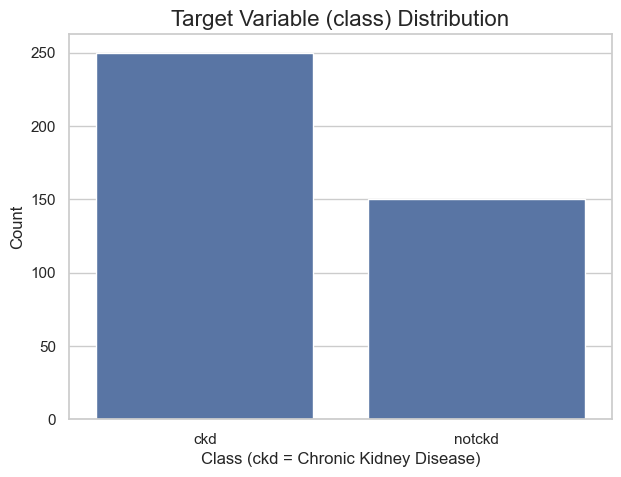

In [ ]:
# --- Target Variable: class ---
plt.figure(figsize=(7, 5))
sns.countplot(x='class', data=df)
plt.title('Target Variable (class) Distribution', fontsize=16)
plt.xlabel('Class (ckd = Chronic Kidney Disease)')
plt.ylabel('Count')
plt.show()

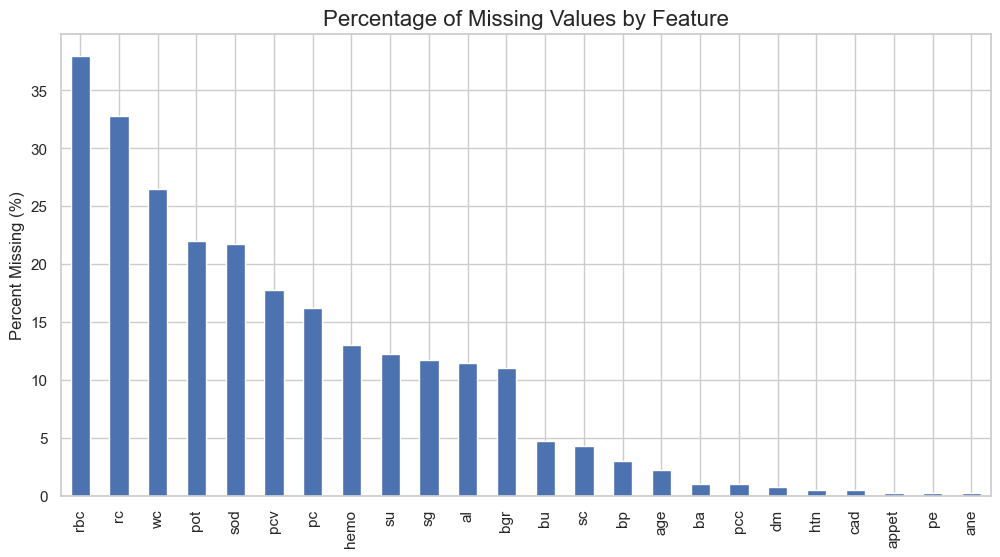

In [ ]:
# --- Missing Value Percentage ---
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)

plt.figure(figsize=(12, 6))
missing_percent.plot(kind='bar')
plt.title('Percentage of Missing Values by Feature', fontsize=16)
plt.ylabel('Percent Missing (%)')
plt.show()

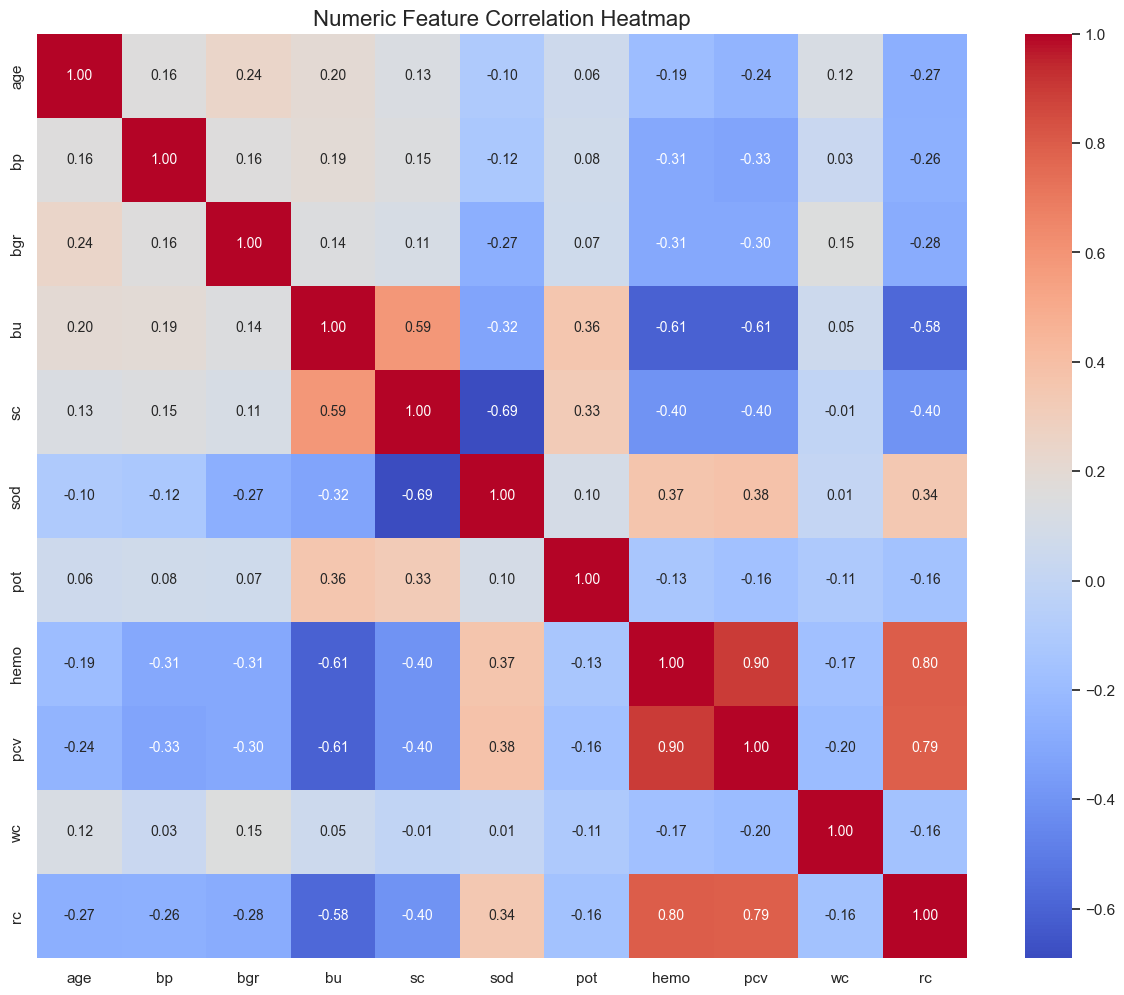

In [ ]:
# --- Correlation Heatmap (Numeric Features) ---
plt.figure(figsize=(15, 12))
correlation_matrix = df[NUMERIC_FEATURES].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', annot_kws={"size": 10})
plt.title('Numeric Feature Correlation Heatmap', fontsize=16)
plt.show()

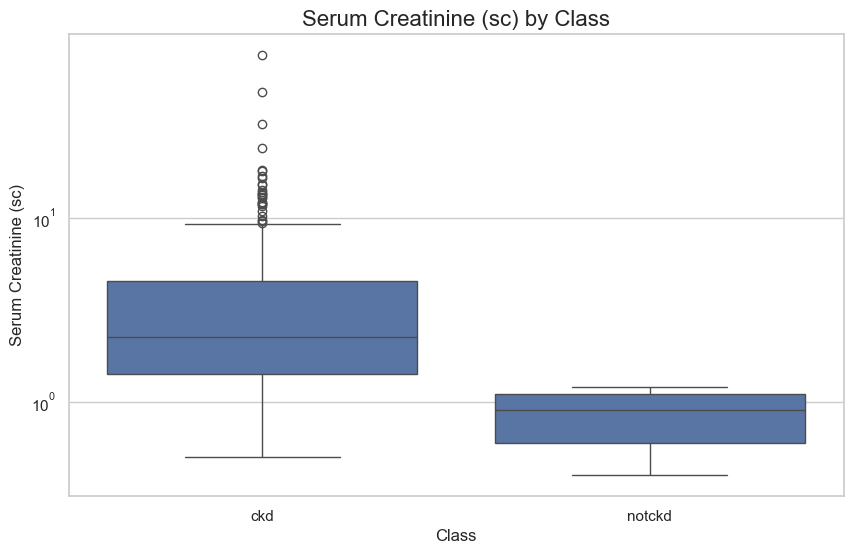

In [ ]:
# --- Box Plot: sc vs. class ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='class', y='sc')
plt.title('Serum Creatinine (sc) by Class', fontsize=16)
plt.xlabel('Class')
plt.ylabel('Serum Creatinine (sc)')
plt.yscale('log') # Use log scale due to high outliers
plt.show()

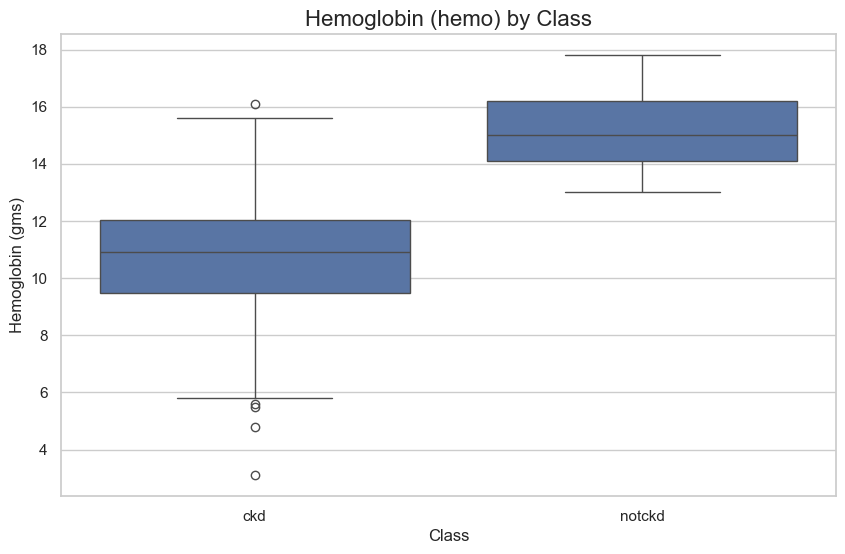

In [ ]:
# --- Box Plot: hemo vs. class ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='class', y='hemo')
plt.title('Hemoglobin (hemo) by Class', fontsize=16)
plt.xlabel('Class')
plt.ylabel('Hemoglobin (gms)')
plt.show()

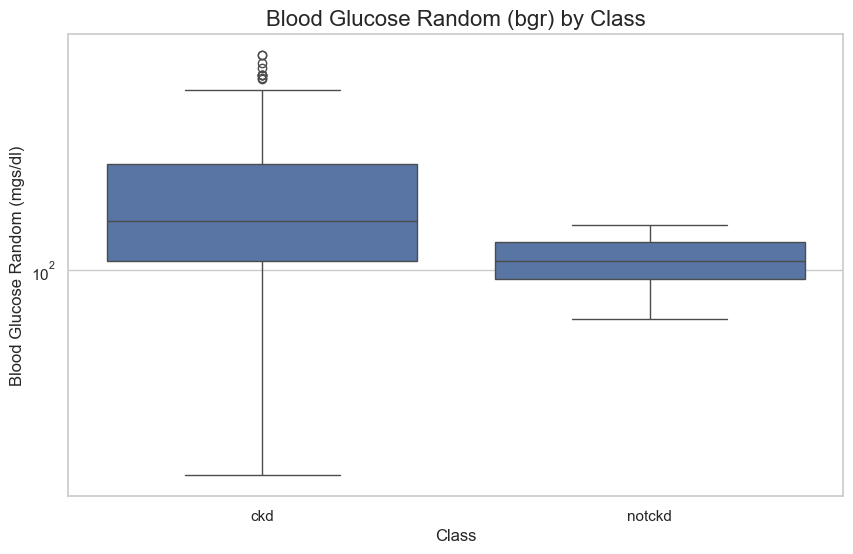

In [ ]:
# --- Box Plot: bgr vs. class ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='class', y='bgr')
plt.title('Blood Glucose Random (bgr) by Class', fontsize=16)
plt.xlabel('Class')
plt.ylabel('Blood Glucose Random (mgs/dl)')
plt.yscale('log') # Use log scale for outliers
plt.show()

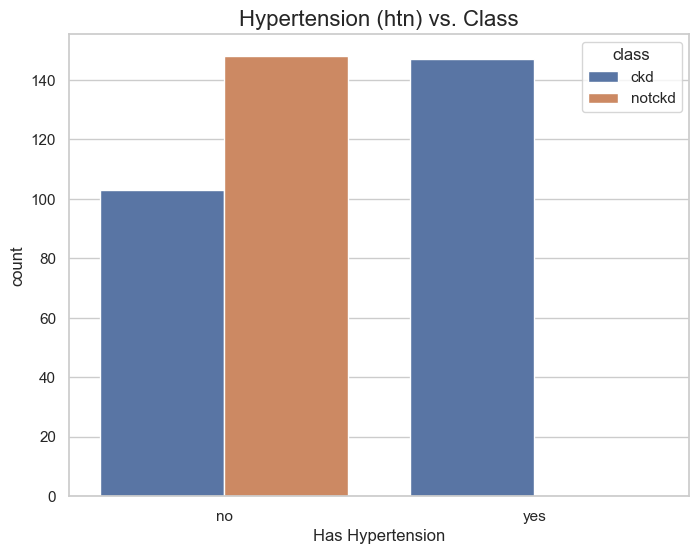

In [ ]:
# --- Count Plot: htn vs. class ---
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='htn', hue='class', order=['no', 'yes'])
plt.title('Hypertension (htn) vs. Class', fontsize=16)
plt.xlabel('Has Hypertension')
plt.show()

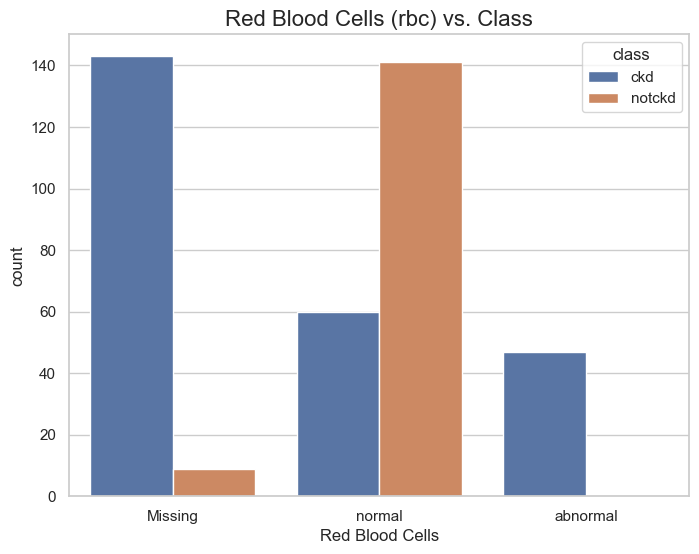

In [ ]:
# --- Count Plot: rbc vs. class ---
plt.figure(figsize=(8, 6))
# Fillna with 'Missing' to visualize the impact of missing data
sns.countplot(data=df.fillna('Missing'), x='rbc', hue='class')
plt.title('Red Blood Cells (rbc) vs. Class', fontsize=16)
plt.xlabel('Red Blood Cells')
plt.show()

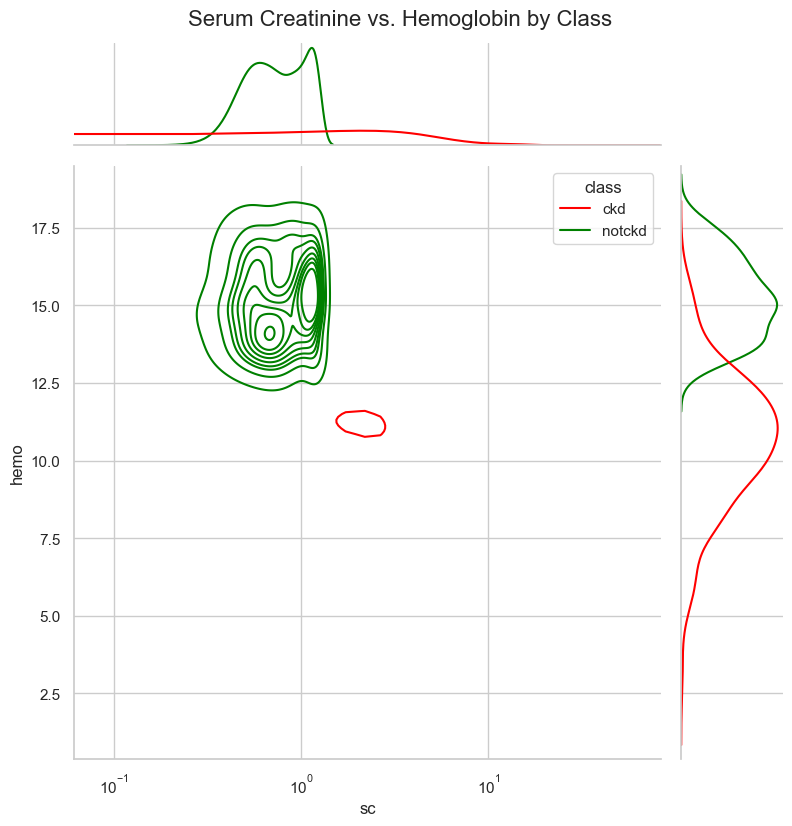

In [ ]:
# --- 2D Density Plot: sc vs. hemo ---
g = sns.jointplot(
    data=df,
    x="sc",
    y="hemo",
    hue="class",
    kind="kde", # Kernel Density Estimate
    height=8,
    palette={'notckd': 'green', 'ckd': 'red'}
)
g.fig.suptitle('Serum Creatinine vs. Hemoglobin by Class', y=1.02, fontsize=16)
# Use log scale for sc due to outliers
g.ax_joint.set_xscale('log') 
plt.show()

In [ ]:
# --- Train-Test Split ---
# Define X (features) and y (target)
X = df.drop('class', axis=1)
y = df['class']

# We must drop rows where the target 'class' is missing
y_known_idx = y.dropna().index
X = X.loc[y_known_idx]
y = y.loc[y_known_idx]

# We use stratify=y because the dataset is imbalanced
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (320, 24)
X_test shape: (80, 24)
y_train shape: (320,)
y_test shape: (80,)


In [ ]:
# --- Define Feature Lists from Metadata ---
NUMERIC_FEATURES = ['age', 'bp', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc']
NOMINAL_FEATURES = ['sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']
print(f"Defined {len(NUMERIC_FEATURES)} numeric and {len(NOMINAL_FEATURES)} nominal features.")

# --- Create Preprocessing Pipelines ---

# Pipeline for NUMERIC data:
# 1. Impute missing values with the mean
# 2. Scale features to have zero mean and unit variance
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Pipeline for NOMINAL data:
# 1. Impute missing values with the most frequent value
# 2. One-Hot Encode the categories
nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# --- Create the Full ColumnTransformer ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, NUMERIC_FEATURES),
        ('nom', nominal_transformer, NOMINAL_FEATURES)
    ],
    remainder='drop' # Drop any columns not listed
)

print("Full preprocessing pipeline defined.")

Defined 11 numeric and 13 nominal features.
Full preprocessing pipeline defined.


In [ ]:
# --- Apply the Preprocessing Pipeline ---

# Fit on training data and transform it
print("Fitting and transforming X_train...")
X_train_processed = preprocessor.fit_transform(X_train)
print("Transforming X_test...")
X_test_processed = preprocessor.transform(X_test)

# --- Label Encode Target ---
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
class_names = le.classes_ # Will be ['ckd', 'notckd']

print(f"\nPreprocessing complete.")
print(f"Original feature count: {X_train.shape[1]}")
print(f"New feature count (after OHE): {X_train_processed.shape[1]}")
print(f"Target classes (encoded): {list(zip(le.classes_, np.unique(y_train_enc)))}")

Fitting and transforming X_train...
Transforming X_test...

Preprocessing complete.
Original feature count: 24
New feature count (after OHE): 48
Target classes (encoded): [('ckd', 0), ('notckd', 1)]


In [ ]:
# --- Define Model Pipeline ---
print("Defining all 9 from-scratch models...")
n_features_final = X_train_processed.shape[1] # Number of features after OHE

# Use "Better Accuracy" parameters
multi_class_models = {
    "KNN": KNN(k=3), # k=3 is often better for small, imbalanced data
    "GNB": GaussianNaiveBayes(),
    "LDA": LDA(),
    "DT": DecisionTreeClassifier(max_depth=10, min_samples_split=3), # Use 3
    "RF": RandomForestClassifier(n_trees=100, max_depth=10, min_samples_split=3),
}

# This is a binary problem, so OvRWrapper will just train one model
binary_models_to_wrap = {
    "LogReg_OvR": (LogisticRegression, 
                   {"learning_rate": 0.01, "n_iters": 1000, "verbose": False}),
    "SVM_OvR": (LinearSVM, 
                {"learning_rate": 0.001, "lambda_param": 0.01, "n_iters": 1000, "verbose": False}),
    "MLP_OvR": (SimpleMLP, 
                {"n_input": n_features_final, "n_hidden": 32, "n_output": 1,
                 "learning_rate": 0.01, "n_iters": 1000, "verbose": False, 
                 "activation": 'relu', "random_state": 42}),
    "AdaBoost_OvR": (AdaBoost, {"n_estimators": 50}),
}

# --- Combine the dictionaries ---
all_models = multi_class_models.copy()
for name, (model_class, kwargs) in binary_models_to_wrap.items():
    all_models[name] = OvRWrapper(model_class, **kwargs)
    
print(f"Total models to train: {len(all_models)}")
print("Models to run:", list(all_models.keys()))

Defining all 9 from-scratch models...
Total models to train: 9
Models to run: ['KNN', 'GNB', 'LDA', 'DT', 'RF', 'LogReg_OvR', 'SVM_OvR', 'MLP_OvR', 'AdaBoost_OvR']


In [ ]:
# --- Run All Models ---
results = {}
reports = {}
models_trained = {} # To store the trained model instances

print("\n--- Running Model Benchmarks on Processed Data ---")

# Wrap the model loop with tqdm for a progress bar
for name, model in tqdm(all_models.items(), desc="Overall Model Progress"):
    try:
        start_time = time.time()
        
        # Train the model
        model.fit(X_train_processed, y_train_enc)
        
        # Predict
        y_pred = model.predict(X_test_processed)
        
        duration = time.time() - start_time
        acc = accuracy_score(y_test_enc, y_pred)
        # Generate report as a dictionary for later use
        report_dict = classification_report(y_test_enc, y_pred, target_names=class_names, output_dict=True, zero_division=0)
        
        results[name] = acc
        reports[name] = report_dict
        models_trained[name] = model # Save the trained model
    
    except Exception as e:
        import traceback
        print(f"  ❌ ERROR training/predicting with {name}: {e}")
        traceback.print_exc() 
        results[name] = 0.0
        reports[name] = str(e)

print("\nAll models trained and evaluated.")


--- Running Model Benchmarks on Processed Data ---


Overall Model Progress:   0%|          | 0/9 [00:00<?, ?it/s]

KNN fitted with 320 samples.
Predicting for 80 samples using KNN (k=3)...
Fitting Gaussian Naive Bayes...
Fitting complete.
Predicting labels for 80 samples using GNB...
Fitting LDA...
LDA fitting complete.
Predicting labels for 80 samples using LDA...
Fitting Decision Tree: max_depth=10, min_split=3, features_per_split=48...
Tree fitting complete.
Predicting labels for 80 samples using Decision Tree...
Fitting Random Forest: 100 trees, max_depth=10, min_split=3, features_per_split=6...
  Tree 10/100 fitted.
  Tree 20/100 fitted.
  Tree 30/100 fitted.
  Tree 40/100 fitted.
  Tree 50/100 fitted.
  Tree 60/100 fitted.
  Tree 70/100 fitted.
  Tree 80/100 fitted.
  Tree 90/100 fitted.
  Tree 100/100 fitted.
Random Forest fitting complete.
Predicting labels for 80 samples using Random Forest (100 trees)...
Starting Logistic Regression training for up to 1000 iterations...
Convergence reached at iteration 744. Cost = 0.157930
Predicting labels for 80 samples using Logistic Regression...
Star

In [ ]:
# --- Final Results Summary ---

print("\n\n" + "="*30)
print("🏁 FINAL ACCURACY SUMMARY 🏁")
print("="*30 + "\n")

# Convert results to a DataFrame for easy sorting
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])
results_df = results_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

# Format accuracy as percentage
results_df['Accuracy'] = results_df['Accuracy'].apply(lambda x: f"{x*100:.2f}%")

print(results_df.to_string())



🏁 FINAL ACCURACY SUMMARY 🏁

          Model Accuracy
0  AdaBoost_OvR   98.75%
1           KNN   97.50%
2    LogReg_OvR   97.50%
3       MLP_OvR   97.50%
4           LDA   96.25%
5            DT   96.25%
6            RF   96.25%
7       SVM_OvR   95.00%
8           GNB   57.50%


In [ ]:
# --- Best Model Classification Report ---

# Get the name and accuracy of the best model (re-sorting by number)
best_model_name = sorted(results.items(), key=lambda item: item[1], reverse=True)[0][0]
best_accuracy = results[best_model_name]

print(f"\n\n--- 🏆 Best Model ---")
print(f"{best_model_name} (Accuracy: {best_accuracy*100:.2f}%)")

# --- Print Classification Report for the Best Model ---
print("\n--- Classification Report for Best Model ---")
best_report_dict = reports[best_model_name]
if isinstance(best_report_dict, dict):
    best_report_df = pd.DataFrame(best_report_dict).transpose()
    print(best_report_df)
else:
    print(best_report_dict) # Print error message if it failed



--- 🏆 Best Model ---
AdaBoost_OvR (Accuracy: 98.75%)

--- Classification Report for Best Model ---
              precision    recall  f1-score  support
ckd            0.980392  1.000000  0.990099  50.0000
notckd         1.000000  0.966667  0.983051  30.0000
accuracy       0.987500  0.987500  0.987500   0.9875
macro avg      0.990196  0.983333  0.986575  80.0000
weighted avg   0.987745  0.987500  0.987456  80.0000


Predicting labels for 80 samples using AdaBoost...


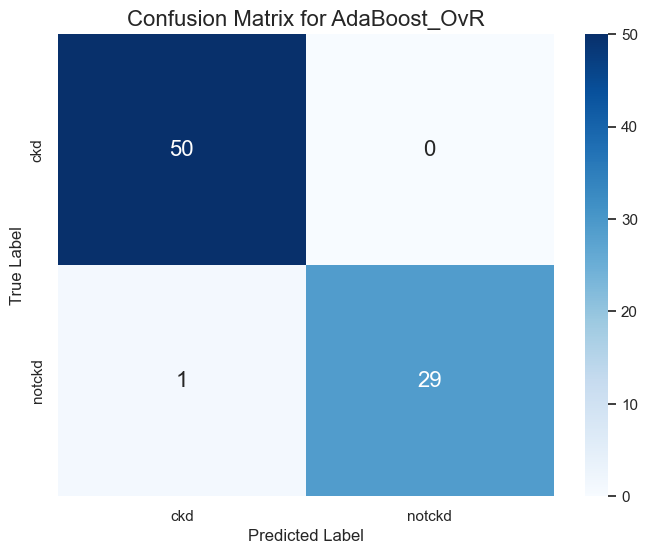

In [ ]:
# --- Confusion Matrix for Best Model ---

# Get the trained model instance
best_model_instance = models_trained[best_model_name]
y_pred_best = best_model_instance.predict(X_test_processed)

cm = confusion_matrix(y_test_enc, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            annot_kws={"size": 16})
plt.title(f'Confusion Matrix for {best_model_name}', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()